Jusqu'à présent, je me suis concentré sur le fichier train.csv mais il y a aussi authorData qui n'a juste pas l'embedding.

J'avais vu que l'embedding n'était pas méga importante mais je vais chercher à la garder. Pour cela, je vais chercher à estimer lesparamètres de l'embedding.

(Notations : D1 = train.csv; D2 = authorData.csv; N = colonnes non-embedding(=explicites parce que je les connais presque qu'elles sont presques lisibles par un humain); M = colonnes embeddées.)

idée : utiliser train pour apprendre l'embedding sur N colonnes pour en prédire m<=M.
M=1024 donc prédire les 1024 est violent. On se propose de prédire les m termes de la pca

Etapes (d'entrainement et calibration du modèle)
* PCA(m) sur M colonnes de train
* diff train, test et X, Y 
* prédiction(m) à partir de N de X_train
  * modèle
  * métrique

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity


from notebook_helper import split_url, explicit_part_preparation, pca_transform

In [2]:
df = pd.read_csv("./data/train.csv", sep=",")

### a. PCA

In [3]:
m = 20
df_reduced = pca_transform(df, n_components=m)

In [4]:
df_reduced.head(3)

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,...,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,15,1655784230254,en,73,0,696,bd20432d80dfe4825a7a106312bda52e,18,0,NaN,...,-0.009128,-0.121310,-0.029760,0.024676,-0.040063,-0.003811,-0.033490,-0.049743,-0.027627,-0.005722
1,91007,1655599613254,en,100,5,17526,71e2ecc6cc1d6515a6b122fab4c63bfc,15,0,NaN,...,-0.098733,0.002273,-0.019757,0.011791,-0.064402,-0.007559,0.003213,-0.094815,-0.069468,-0.000877
2,3,1655788872254,en,0,-5,239,2a9109f38d90a2a96e284a07c1a57e9b,8,0,NaN,...,-0.026813,-0.009200,-0.063982,0.004020,0.000472,-0.022285,-0.022624,0.027581,-0.021913,0.045950


### b. entraînement

In [5]:
df_prepared = explicit_part_preparation(df_reduced)

In [6]:
df_prepared.head(3)

,engagement,timestamp,feature2,followers,word_count,is_reply,contains_video,contains_image,V1,V2,...,shared_url_extension_net,shared_url_extension_news,shared_url_extension_org,shared_url_extension_other,shared_url_extension_tv,is_shared_url,month_post,day_of_week_post,hour_post,feature1_is_max
0,1.176091,6.727053,0,2.842609,1.278754,False,False,True,0.040117,0.039279,...,False,False,False,True,False,False,6,1,4,False
1,4.959075,8.278642,5,4.243683,1.204120,False,False,False,-0.154545,0.130231,...,False,False,False,True,False,False,6,6,0,True
2,0.477121,5.840107,-5,2.378398,0.954243,True,False,False,0.319861,-0.050030,...,False,False,False,True,False,False,6,1,5,False


#### i) Linear Regression

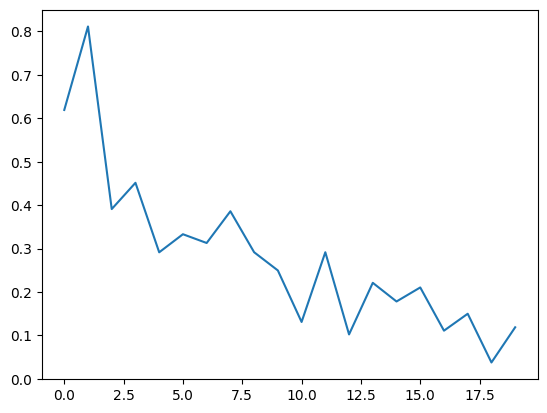

In [7]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

from sklearn.linear_model import LinearRegression
base = LinearRegression()

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [8]:
y_pred

array([[ 1.14438971e-01, -1.45703112e-01, -8.28217403e-01, ...,
        -5.53102956e-02,  1.42118944e-01,  1.73987069e-04],
       [ 4.15558465e-02, -5.28289629e-01, -1.83675760e-01, ...,
        -2.08509425e-01,  2.39108227e-02, -3.06183794e-02],
       [ 3.27354325e-01, -1.03098294e+00, -3.74598870e-01, ...,
         9.82504436e-02,  1.89961123e-03,  1.39216416e-01],
       ...,
       [-1.00854781e+00,  8.65220685e-02,  4.51134131e-01, ...,
         1.45416131e-01,  3.41260145e-03,  1.27322958e-01],
       [ 3.72797960e-01, -6.77238178e-01,  3.60849140e-01, ...,
         3.76103678e-02, -2.35229400e-02, -8.28420519e-03],
       [-2.16177844e-01, -1.23220324e+00,  1.53153348e-01, ...,
         2.04891504e-02, -5.61646167e-02,  1.40019852e-01]],
      shape=(830, 20))

In [9]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.7855591168981391
0.5849318103011762
0.9204551848769291
0.8923346843678029
0.9578549843162008
0.9433793708122907
0.9501874921676552
0.9230848531175382
0.9571768523525159
0.9688857308087873
0.9930390020587552
0.9574526956135934
0.9968956199624401
0.9755224269299286
0.9840970321045404
0.977648605646049
0.9957221174170288
0.9889328252308237
1.0020933332150086
0.994070907025897


In [10]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [11]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [12]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.6079060137794917
0.4170054675782964
0.7330068065593941
0.684023477969294
0.7553126501702964
0.7462340295872383
0.7351155463314324
0.6809726704617681
0.7600589437587154
0.7737970335470444
0.8053580788268772
0.7685988524576763
0.7991934019521153
0.7819453819776482
0.7850140235854963
0.7839048619140027
0.7938466209839499
0.7746271643795238
0.794557689318393
0.789472645183282


In [13]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7384975680160968)

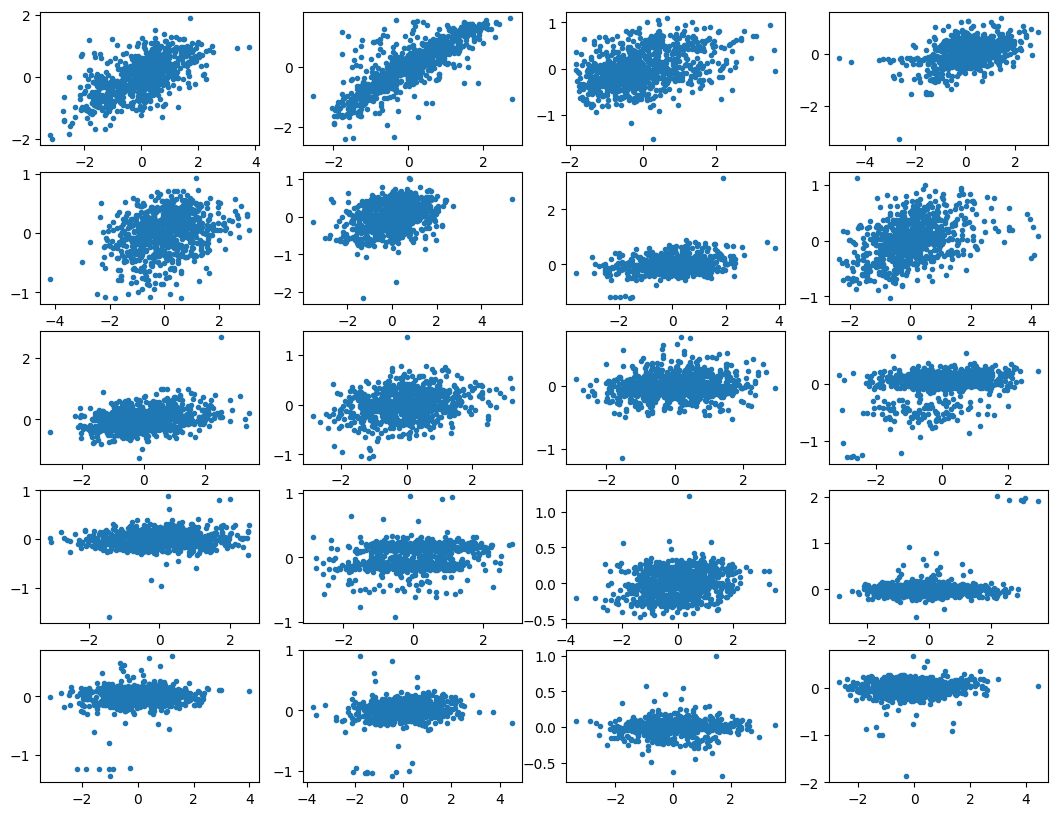

In [14]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### ii) Forêt Aléatoire

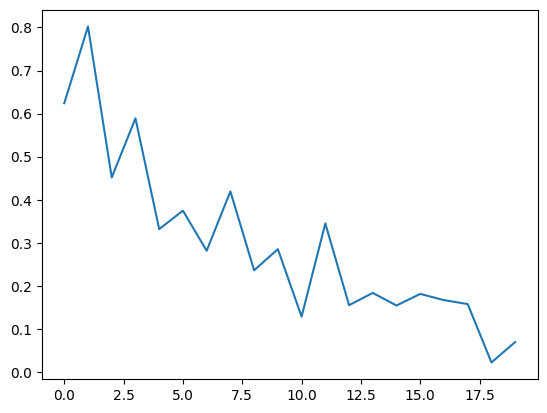

In [15]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
from sklearn.ensemble import RandomForestRegressor

base = RandomForestRegressor(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [16]:
y_pred

array([[ 0.35545533, -0.56853129, -0.95469604, ...,  0.23951137,
         0.10886083, -0.01489355],
       [-0.10824654, -0.53720359, -0.06433502, ..., -0.11453442,
        -0.23182328, -0.17635708],
       [ 0.09758583, -0.99285152, -0.51248053, ..., -0.22294145,
        -0.1120972 ,  0.32847124],
       ...,
       [-0.78496697,  0.07307713,  0.89208944, ...,  0.16205858,
        -0.2136586 ,  0.01808057],
       [ 0.73460922, -0.47960247,  0.44898524, ..., -0.17849187,
         0.10838031,  0.15241524],
       [-0.17890881, -1.2228794 ,  0.12315723, ...,  0.05769992,
        -0.44339446, -0.16815985]], shape=(830, 20))

In [17]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.7826006366632478
0.5970544907562095
0.894299024583788
0.8109548337747389
0.9544453470073972
0.9346187071977063
0.9740772440182843
0.912468458143437
0.987169378088586
0.9688071245364405
1.014818643950674
0.9453632618524326
1.006663040177134
0.9979266806173112
1.012409194343564
1.0019888595219841
1.0029613612528754
1.0034248265816677
1.0321475996496172
1.0309445128769752


In [18]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [19]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [20]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.5968310256075648
0.4204218447848302
0.707980397910492
0.6089115121015306
0.7535220354060727
0.7319660239956101
0.759261485465557
0.6728711066990825
0.7867354875291371
0.770576283317896
0.8215414542564815
0.7512763179948446
0.8025445245240348
0.8014001287853777
0.8087108196905942
0.7984471615638784
0.8051425180908431
0.7828961345778699
0.8206110646442597
0.8198614269583665


In [21]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7410754376952161)

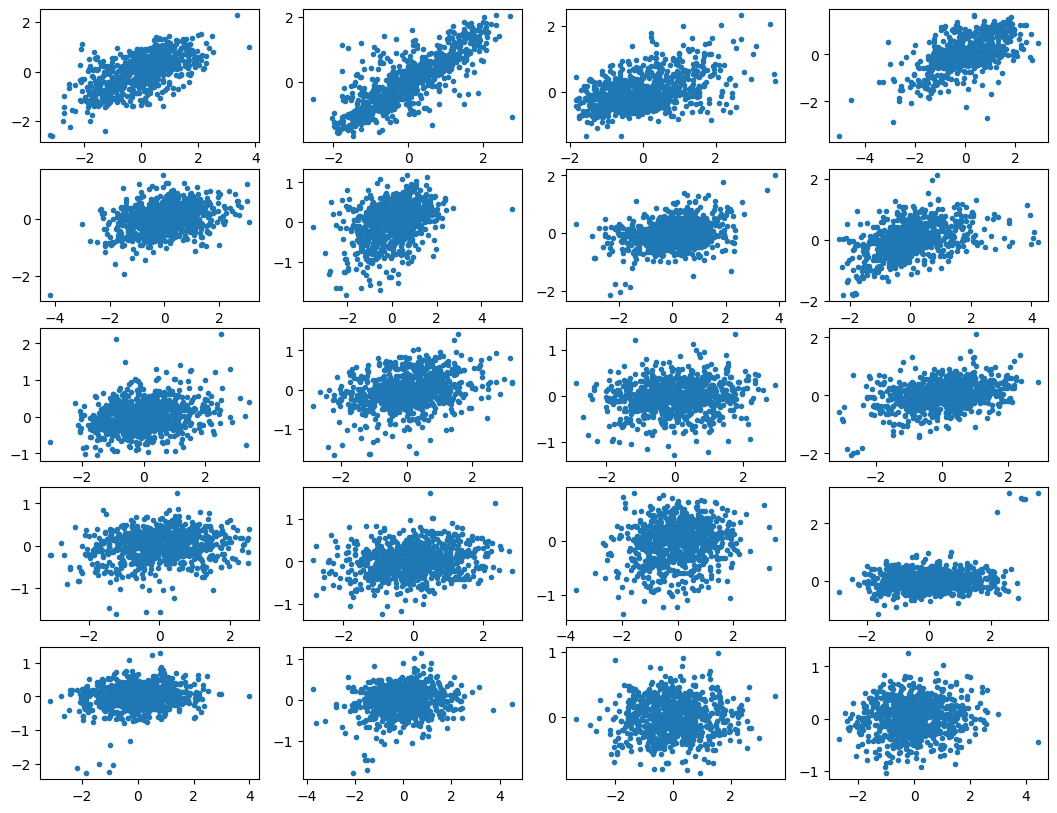

In [22]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### iii) XGBoost 

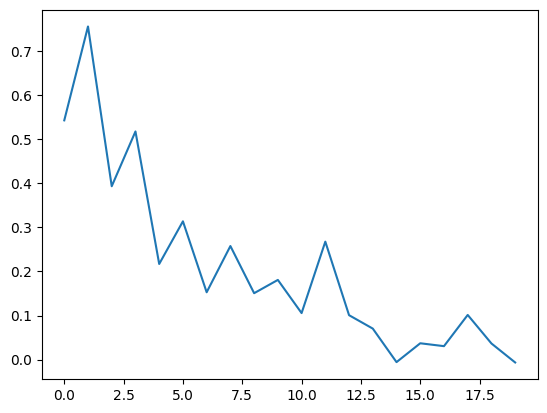

In [23]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
import xgboost as xgb

base = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [24]:
y_pred

array([[-0.21323924, -0.42661032, -1.318381  , ...,  0.9369209 ,
        -0.44297433, -0.93274516],
       [-0.5075253 , -0.49471143, -0.54973036, ..., -0.01125039,
         0.18914641,  0.5989267 ],
       [-0.13955534, -1.0733856 , -0.66772467, ...,  0.29286286,
        -0.33942845,  0.62534493],
       ...,
       [-0.8697919 ,  0.31352162,  0.67879045, ...,  0.12920798,
         0.09745894, -0.10031734],
       [ 0.6717615 , -0.4058814 ,  0.09335781, ...,  0.01583095,
        -0.03159295,  0.5398615 ],
       [ 0.74865055, -0.9799794 , -0.9168135 , ...,  0.08067834,
        -0.26197454, -0.2504684 ]], shape=(830, 20), dtype=float32)

In [25]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.8517150193323916
0.6642160828111354
0.942595015419131
0.8791041367203261
1.0524357104361972
0.9990294581587472
1.048428388203877
1.0407444110204223
1.1224723264377374
1.0823203212367711
1.0678777358799068
1.0064191937791953
1.091392658516294
1.0654171433472266
1.1005457086407904
1.0770458230188553
1.0905853037352313
1.047950615671984
1.085902126777359
1.1244269933445987


In [26]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [27]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [28]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.6579261008209606
0.48283613481012183
0.7483890045904247
0.6712754357482786
0.840772732267942
0.782333047024646
0.8153893014931577
0.7782337763988411
0.8935425634415252
0.8731104905358548
0.8584323490909276
0.8010392387120112
0.8684907973790362
0.8536577341423083
0.8772556598127226
0.8550439617346309
0.876433110470857
0.826173488995328
0.8567464263557675
0.8963579232555833


In [29]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.8056719638540464)

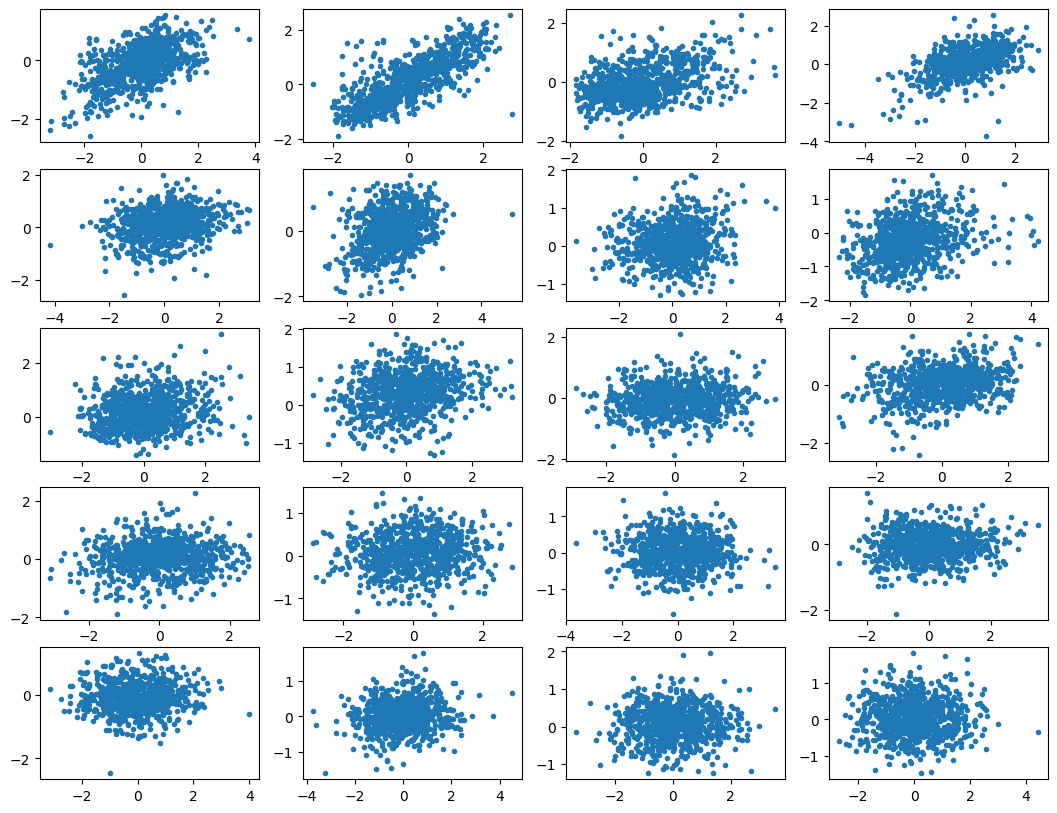

In [30]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### iv) LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 3320, number of used features: 16
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 3320, number of used features: 16
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Us

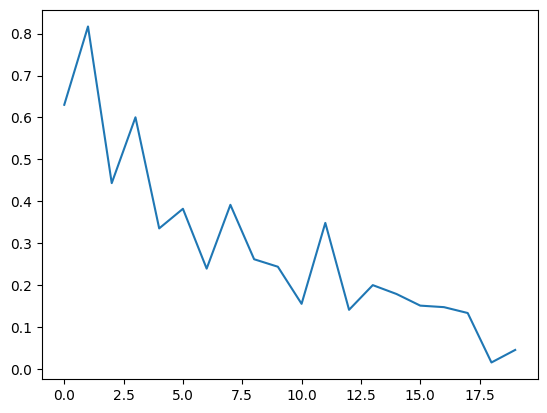

In [31]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
base = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [32]:
y_pred

array([[ 0.20678041, -0.68848296, -1.39206071, ...,  1.05169377,
         0.28818914,  0.0111743 ],
       [-0.3587016 , -0.72248254, -0.26688736, ..., -0.37523115,
        -0.24730884, -0.14630424],
       [ 0.25803457, -1.21794632, -0.63341584, ..., -0.08603779,
        -0.24190065,  0.67084826],
       ...,
       [-1.19244813,  0.16095511,  0.72984088, ...,  0.16687458,
        -0.02868315,  0.26295191],
       [ 0.85431114, -0.5970501 ,  0.21710442, ..., -0.07950098,
         0.1162996 , -0.01496039],
       [ 0.45268285, -1.26391363,  0.15217943, ...,  0.18351841,
         0.06462761, -0.5913894 ]], shape=(830, 20))

In [33]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.777520298010335
0.5766814419228548
0.9000885693235129
0.8009124139325873
0.9560391785501965
0.9307737631441765
0.9886862704603608
0.9266777214541915
0.9764170918809912
0.9871377850690335
1.0085182289033745
0.9431427649532094
1.0154565379681213
0.9906306858924996
1.0057123962704033
1.0121327953791037
1.0108080979613232
1.011081641935749
1.0408581603982165
1.0420269354568095


In [34]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [35]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [36]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.594619981048113
0.4081728652388566
0.7100460017031271
0.601668520001804
0.7544862599621227
0.72884444296596
0.7681600378401038
0.6929052738353015
0.7722170817631099
0.77838217126584
0.8151838367563543
0.7476051448976899
0.8084315049959072
0.797066696562411
0.8052917169781151
0.814136133754094
0.8161430459877815
0.7906688772815924
0.8236971144160015
0.8267903094906859


In [37]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7427258508372485)

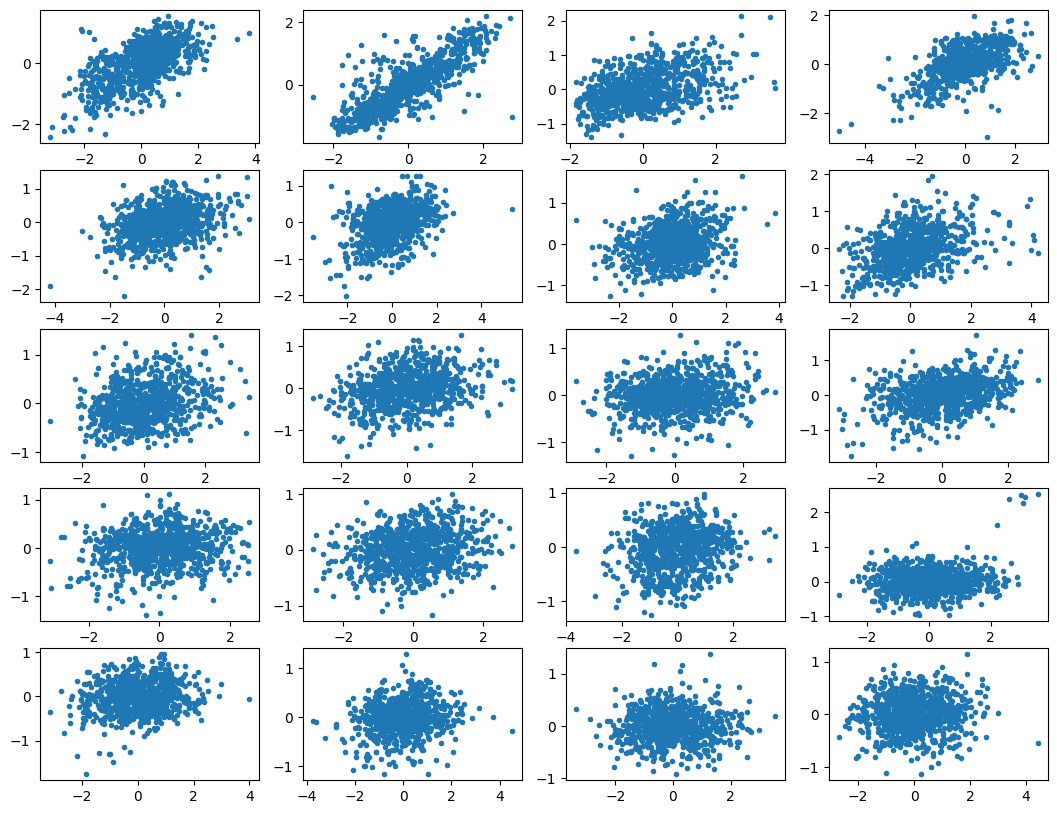

In [38]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### v) Régression Ridge

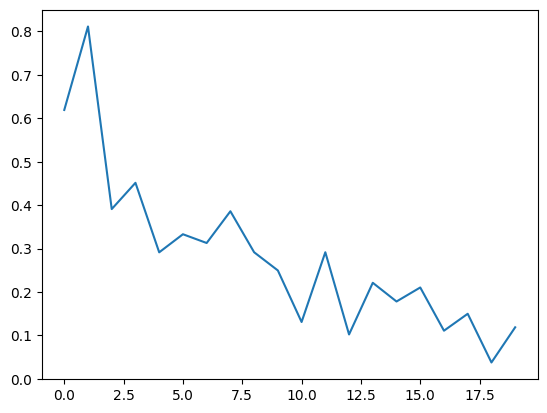

In [39]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
from sklearn.linear_model import Ridge
base = Ridge(alpha=1.0)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [40]:
y_pred

array([[ 1.14578041e-01, -1.45469496e-01, -8.27849810e-01, ...,
        -5.53087649e-02,  1.42095757e-01,  1.88227462e-04],
       [ 4.15608711e-02, -5.28333686e-01, -1.83707005e-01, ...,
        -2.08400152e-01,  2.39174925e-02, -3.05867646e-02],
       [ 3.27274265e-01, -1.03069819e+00, -3.74315403e-01, ...,
         9.82239955e-02,  1.89755695e-03,  1.39150505e-01],
       ...,
       [-1.00829731e+00,  8.65501263e-02,  4.50987787e-01, ...,
         1.45364214e-01,  3.38242405e-03,  1.27282768e-01],
       [ 3.72662088e-01, -6.77181665e-01,  3.60680748e-01, ...,
         3.75870589e-02, -2.35583404e-02, -8.30940011e-03],
       [-2.16116846e-01, -1.23187727e+00,  1.53361772e-01, ...,
         2.04544263e-02, -5.61906408e-02,  1.39863257e-01]],
      shape=(830, 20))

In [41]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.7855562759202334
0.5849414420859735
0.920451796485429
0.8923365016162558
0.9578484686058186
0.9433723127352492
0.9501819408362793
0.9230705502862626
0.9571747044245815
0.9688738013766254
0.9930358161022232
0.9574468125124863
0.9968925656535763
0.9755001789374078
0.984090450315655
0.9776501850152489
0.9957169697506847
0.988931667285322
1.0020769564733958
0.9940526367170484


In [42]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [43]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [44]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.6079115158512907
0.4170573893723806
0.7330001749684495
0.6840138858896342
0.7553023403272955
0.7462346026898146
0.7351146945977521
0.6809615790337762
0.7600588933256286
0.7737866485139648
0.8053554432013621
0.7685977107817902
0.7991898733787707
0.7819251913533194
0.7850121193174006
0.7839061444474246
0.7938443425885597
0.7746285610238274
0.7945483329544551
0.7894748407070031


In [45]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.738496214216195)

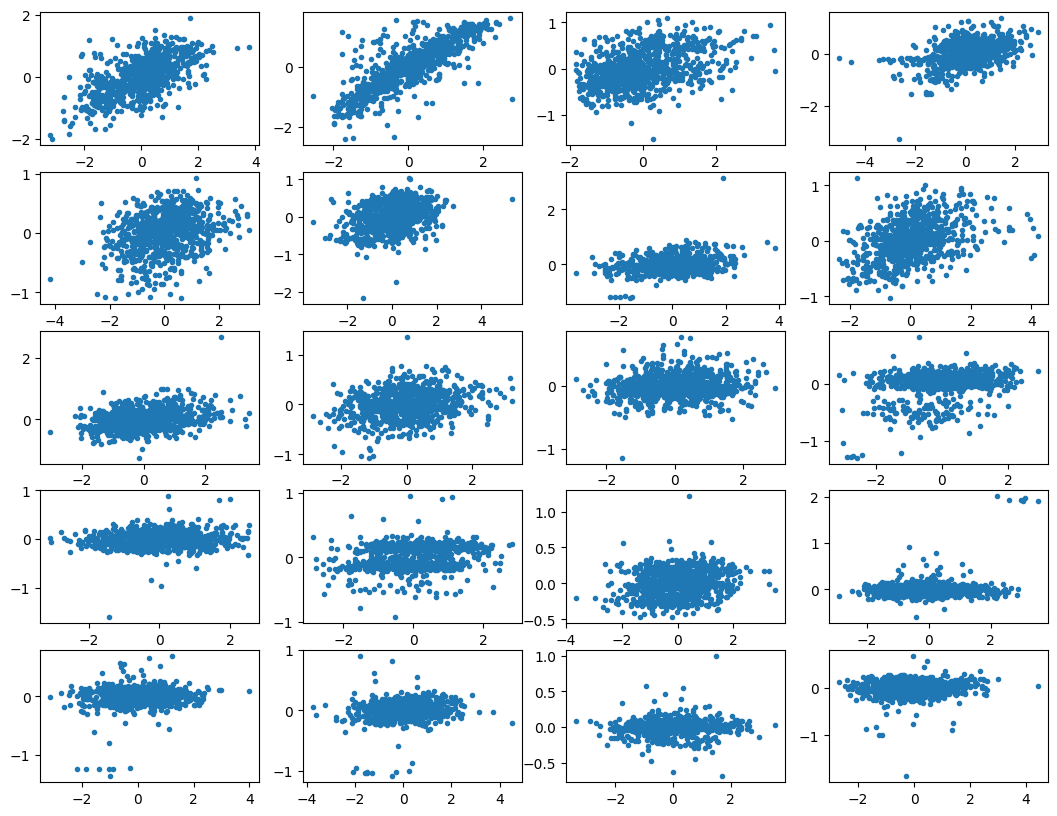

In [46]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### vi) Régression par voisins

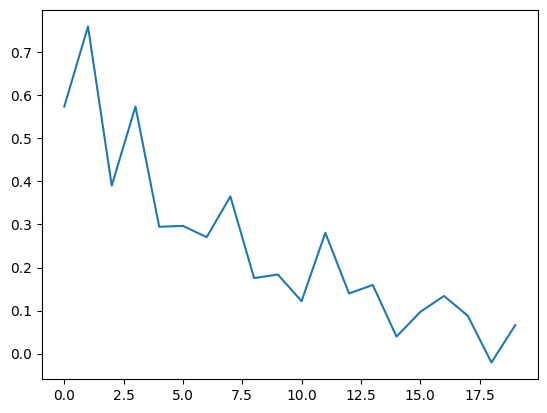

In [47]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
from sklearn.neighbors import KNeighborsRegressor
base = KNeighborsRegressor(n_neighbors=5)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [48]:
y_pred

array([[ 0.45735969, -0.41280943, -0.87670445, ...,  0.97574574,
         0.85624577,  0.33955287],
       [-0.19040258, -0.77326503, -0.98553341, ...,  0.32590629,
        -0.01854205,  0.00400519],
       [ 0.25133514, -1.41603075, -1.04361475, ..., -0.06948076,
         0.13395678,  0.06045915],
       ...,
       [-1.07825203,  0.37736694,  1.08674017, ...,  0.39033955,
        -0.04444575,  0.33150645],
       [ 0.55504738, -1.02140051, -0.29503301, ..., -0.26637952,
        -0.37756343,  0.54030326],
       [-0.5720133 , -1.01166859,  0.27090661, ...,  0.20818928,
        -0.7171066 , -0.01430942]], shape=(830, 20))

In [49]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.8294315143890438
0.650290932398055
0.9479002062249609
0.8267971618477018
0.9901504605759965
0.9967917753814888
1.003808350380207
0.954223131352812
1.0427603389150508
1.046032153393517
1.054540111089347
1.0037350658523532
1.0562919975283693
1.0428253207232967
1.09981043716234
1.0871973186111408
1.0645750781044292
1.0641057338086564
1.110785606676497
1.0793643516871438


In [50]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [51]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [52]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.6392715704616495
0.4782585049754821
0.7325936924992271
0.63684663344241
0.7793816541029691
0.7776863972522585
0.7765655760787362
0.7067864220758316
0.8274499315054259
0.8383709841266831
0.8505906266037956
0.7994566473684431
0.838829503889658
0.8305647896308082
0.869074777124975
0.858755575585427
0.8318720954713884
0.834866403250272
0.877497700374136
0.8623233967621089


In [53]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7823521441290842)

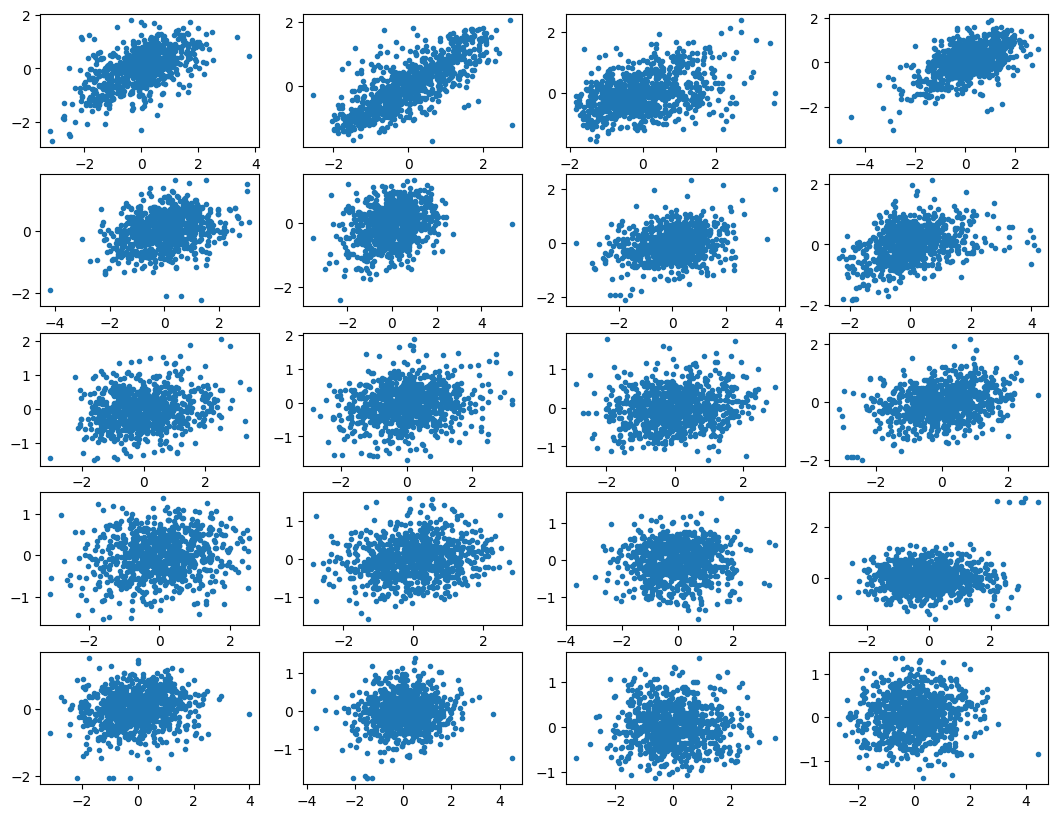

In [54]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### vii) Chaîne de Régresseurs

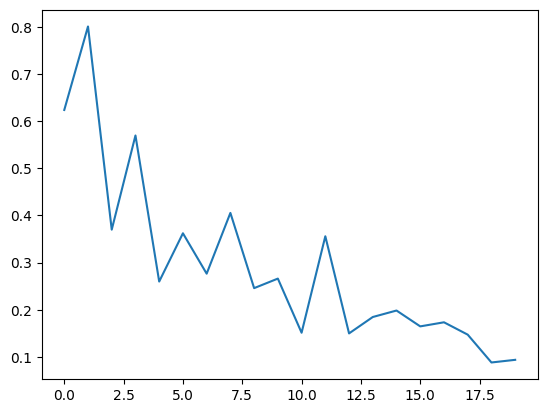

In [55]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
from sklearn.multioutput import RegressorChain
base = RandomForestRegressor(random_state=42)

model = RegressorChain(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [56]:
y_pred

array([[ 0.35545533, -0.28178264, -1.34897084, ...,  0.7133209 ,
         0.2075984 ,  0.05784598],
       [-0.10824654, -0.91569331, -1.12098789, ..., -0.00932653,
        -0.0468874 ,  0.00394354],
       [ 0.09758583, -1.40836193, -1.26577251, ...,  0.44047714,
        -0.18127467, -0.49886057],
       ...,
       [-0.78496697,  0.12241653,  0.57519754, ...,  0.10371987,
        -0.13015064, -0.07760942],
       [ 0.73460922, -0.66875541, -0.13101902, ..., -0.23655148,
         0.07289042,  0.02872264],
       [-0.17890881, -1.49426831, -1.13260225, ...,  0.10365924,
        -0.45780693, -0.57555715]], shape=(830, 20))

In [57]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.7826006366632478
0.6058855020315028
0.9686829346118545
0.8270982329026356
0.9776507082552248
0.9384822804664857
0.9765080283635328
0.9190051088709895
0.9832851798128789
0.9685823494948714
1.00888799040693
0.9397505405203916
0.9984017525023954
1.0003600650305777
0.986672066511432
1.0099504806473765
0.989977246717008
0.9935262936123781
1.0017631081474958
1.0083967485458238


In [58]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [59]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [60]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.5968310256075648
0.40935088912425227
0.7185732561186703
0.6210204937396209
0.7541769950125141
0.7360620155586574
0.7589364521356242
0.6676831847029376
0.7783148163144556
0.770964998155913
0.8080632658819532
0.7513178539295928
0.8016503277052491
0.8010778725455954
0.7890367736951848
0.8060357962449819
0.7935822231319835
0.7736188703546413
0.7938763250667371
0.7967472074970425


In [61]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7363460321261586)

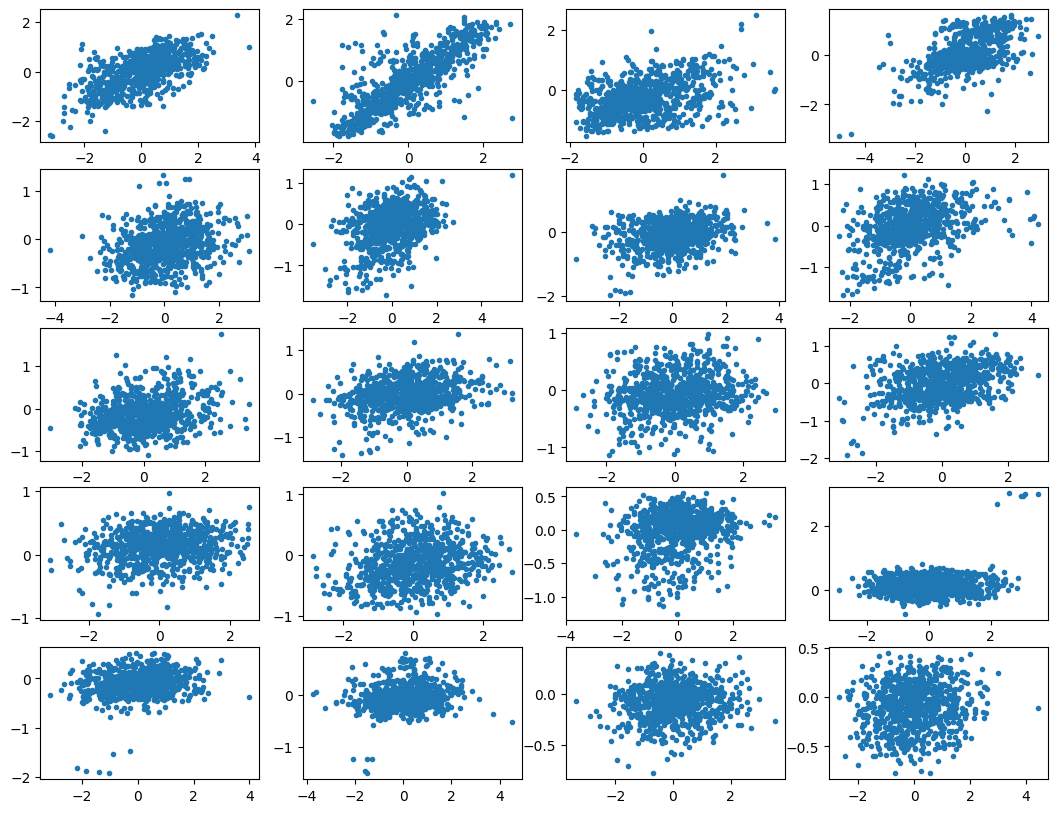

In [62]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")

#### viii) MLP

c:\Users\mathi\dev\ml2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.0128
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9263
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8938
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8787
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8691
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8610
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8556
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8499
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8473
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8428
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8391
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8365
Epoch 13/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8331
Epoch 14/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8303
Epoch 15/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

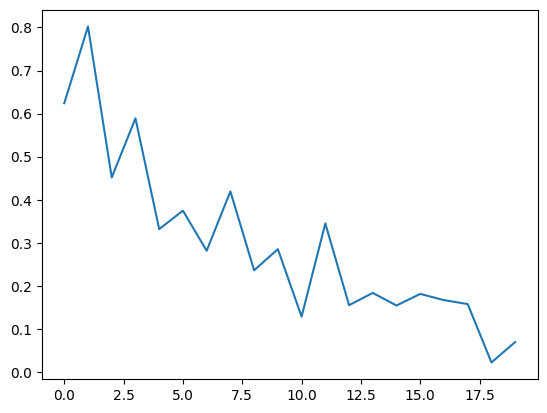

In [63]:
V_cols = [col for col in df_prepared.columns if "V" in col]

# Separation of the target
X = df_prepared.drop(columns=V_cols)
y = df_prepared[V_cols]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Normalisation
sc_X, sc_y = StandardScaler(), StandardScaler()
X_train, y_train = sc_X.fit_transform(X_train), sc_y.fit_transform(y_train)
X_test, y_test = sc_X.fit_transform(X_test), sc_y.fit_transform(y_test)

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

N_cols = X_train.shape[1]  # N_cols est le nombre de colonnes dans X_train (les N colonnes transformées)
M_cols = y_train.shape[1]  # M_cols est le nombre de colonnes dans y_train (les composantes PCA)

model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(N_cols,)),
    Dense(64, activation='relu'),
    Dense(M_cols, activation='linear') # Une sortie pour chaque composante PCA
])

model_mlp.compile(optimizer='adam', loss='mse')
model_mlp.fit(X_train, y_train, epochs=50, batch_size=32)

model = MultiOutputRegressor(base)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
cos_sim_matrix = cosine_similarity(y_test.T, y_pred.T)
cos_sim = np.diag(cos_sim_matrix)
plt.plot(cos_sim)

In [64]:
y_pred

array([[ 0.35545533, -0.56853129, -0.95469604, ...,  0.23951137,
         0.10886083, -0.01489355],
       [-0.10824654, -0.53720359, -0.06433502, ..., -0.11453442,
        -0.23182328, -0.17635708],
       [ 0.09758583, -0.99285152, -0.51248053, ..., -0.22294145,
        -0.1120972 ,  0.32847124],
       ...,
       [-0.78496697,  0.07307713,  0.89208944, ...,  0.16205858,
        -0.2136586 ,  0.01808057],
       [ 0.73460922, -0.47960247,  0.44898524, ..., -0.17849187,
         0.10838031,  0.15241524],
       [-0.17890881, -1.2228794 ,  0.12315723, ...,  0.05769992,
        -0.44339446, -0.16815985]], shape=(830, 20))

In [65]:
for k in range(len(y_test.T)):
    print(np.sqrt(np.mean((y_pred.T[k] - y_test.T[k])**2)))

0.7826006366632478
0.5970544907562095
0.894299024583788
0.8109548337747389
0.9544453470073972
0.9346187071977063
0.9740772440182844
0.912468458143437
0.987169378088586
0.9688071245364405
1.014818643950674
0.9453632618524326
1.006663040177134
0.9979266806173112
1.012409194343564
1.0019888595219841
1.0029613612528754
1.0034248265816677
1.0321475996496172
1.0309445128769752


In [66]:
# # Model training
# base = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=12,
#     random_state=42,
# )
# model = MultiOutputRegressor(base)
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)


In [67]:
# # Separation of the target
# X = df_prepared.drop(columns=V_cols)
# y = df_prepared[V_cols]

# # Model training
# base_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
# multi_lgb = MultiOutputRegressor(base_lgb)

# # Grid des hyperparamètres à tester
# param_grid = {
#     'estimator__num_leaves': [31, 63],
#     'estimator__max_depth': [8, 12, 16],
#     'estimator__n_estimators': [300, 500, 1000],
#     'estimator__learning_rate': [0.05, 0.1]
# }

# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=multi_lgb,
#     param_grid=param_grid,
#     scoring=mean_squared_error,
#     cv=cv,
#     verbose=2,
# )

# grid_search.fit(X, y)


In [68]:
for k in range(len(y_test.T)):
    print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))

0.5968310256075648
0.42042184478483025
0.707980397910492
0.6089115121015306
0.7535220354060727
0.7319660239956101
0.759261485465557
0.6728711066990825
0.7867354875291372
0.770576283317896
0.8215414542564815
0.7512763179948446
0.8025445245240348
0.8014001287853777
0.8087108196905941
0.7984471615638785
0.8051425180908431
0.7828961345778699
0.8206110646442597
0.8198614269583665


In [69]:
np.mean(np.abs(y_pred - y_test))

np.float64(0.7410754376952161)

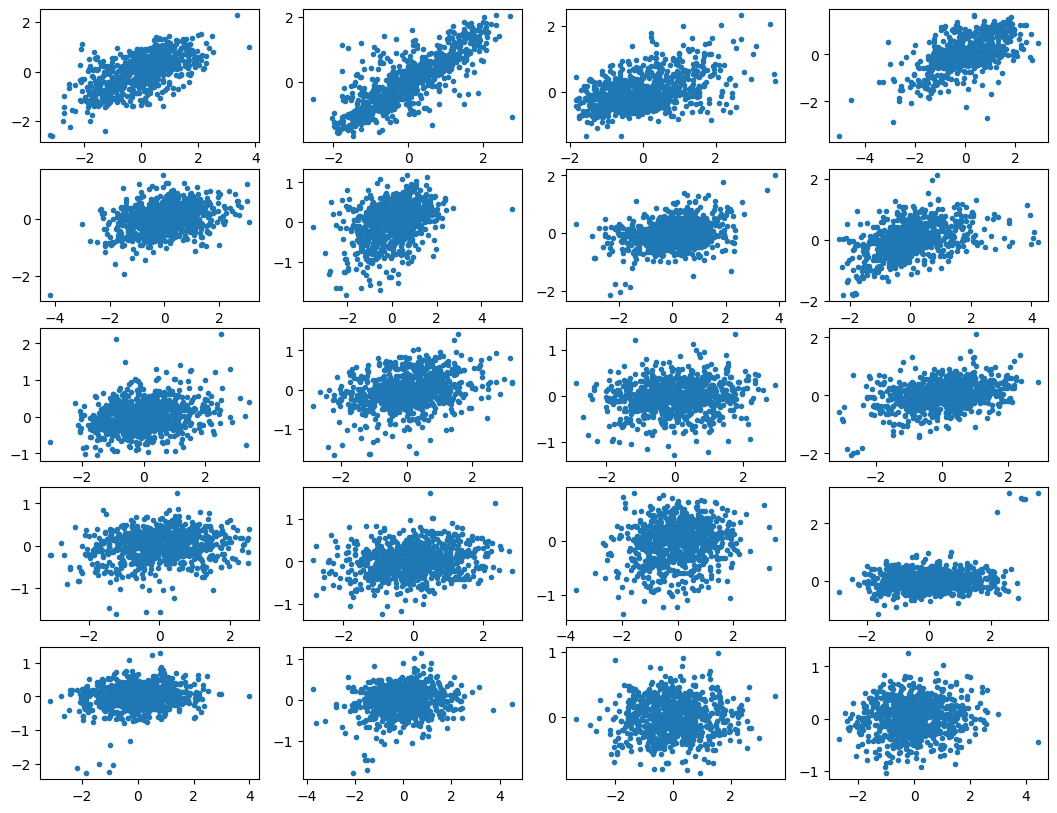

In [70]:
plt.figure(figsize=(13, 10))

for k in range(len(y_test.T)):
    plt.subplot(5,4,k+1)
    # print(np.mean(np.abs(y_pred.T[k] - y_test.T[k])))
    plt.plot(y_test.T[k], y_pred.T[k], ".")